In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import harmonypy as hm
import faiss

import scSLAT
from scSLAT.model import run_SLAT_multi,load_anndatas, Cal_Spatial_Net, run_SLAT, scanpy_workflow, spatial_match
from scSLAT.viz import match_3D_multi, build_3D, hist, Sankey, match_3D_celltype
from scSLAT.metrics import region_statistics

In [3]:
adata1 = sc.read_h5ad('./adata1.h5ad')
adata2 = sc.read_h5ad('./adata2.h5ad')

In [4]:
adata_all = adata1.concatenate(adata2)
adata_all = scanpy_workflow(adata_all)
harm = hm.run_harmony(adata_all.obsm['X_pca'], adata_all.obs, 'batch', max_iter_harmony=20)
Z = harm.Z_corr.T
adata_all.obsm['X_harmony'] = Z

/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
2023-01-24 16:40:04,386 - harmonypy - INFO - Iteration 1 of 20
2023-01-24 16:40:09,917 - harmonypy - INFO - Iteration 2 of 20
2023-01-24 16:40:15,230 - harmonypy - INFO - Iteration 3 of 20
2023-01-24 16:40:20,696 - harmonypy - INFO - Iteration 4 of 20
2023-01-24 16:40:26,153 - harmonypy - INFO - Iteration 5 of 20
2023-01-24 16:40:31,506 - harmonypy - INFO - Iteration 6 of 20
2023-01-24 16:40:34,245 - harmonypy - INFO - Iteration 7 of 20
2023-01-24 16:40:37,438 - harmonypy - INFO - Iteration 8 of 20
2023-01-24 16:40:39,986 - harmonypy - INFO - Converged after 8 iterations


In [5]:
adata1.obsm['X_harmony'] = Z[:adata1.shape[0],:]
adata2.obsm['X_harmony'] = Z[adata1.shape[0]:,:]
embd0 = torch.from_numpy(adata1.obsm['X_harmony'])
embd1 = torch.from_numpy(adata2.obsm['X_harmony'])

In [6]:
best, index, distance = spatial_match([embd0, embd1], reorder=False)
matching = np.array([range(index.shape[0]), best])

In [7]:
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                          'x': adata1.obsm['spatial'][:,0],
                          'y': adata1.obsm['spatial'][:,1],
                          'celltype': adata1.obs['annotation']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                          'x': adata2.obsm['spatial'][:,0],
                          'y': adata2.obsm['spatial'][:,1],
                          'celltype': adata2.obs['annotation']})
matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]
region_statistics(best_match, start=0.5, number_of_interval=10)

0.500~0.550         6          0.060%
0.550~0.600        43          0.430%
0.600~0.650       159          1.590%
0.650~0.700       418          4.180%
0.700~0.750       814          8.139%
0.750~0.800      1339         13.389%
0.800~0.850      1816         18.158%
0.850~0.900      2109         21.088%
0.900~0.950      2251         22.508%
0.950~1.000      1039         10.389%


dataset1: 18 cell types; dataset2: 22 cell types; 
                    Total :29 celltypes; Overlap: 11 cell types 
                    Not overlap :[['Dermomyotome', 'Sclerotome', 'Surface ectoderm', 'Head mesenchyme', 'Inner ear', 'Branchial arch', 'Spinal cord', 'Cartilage primordium', 'Mucosal epithelium', 'Mesentery', 'Choroid plexus', 'Pancreas', 'Ovary', 'Muscle', 'Epidermis', 'Mesothelium', 'Kidney', 'Sympathetic nerve']]
Subsample 300 cell pairs from 10001


/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:242: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.celltypes = set(self.dataset_A[meta].append(self.dataset_B[meta]))


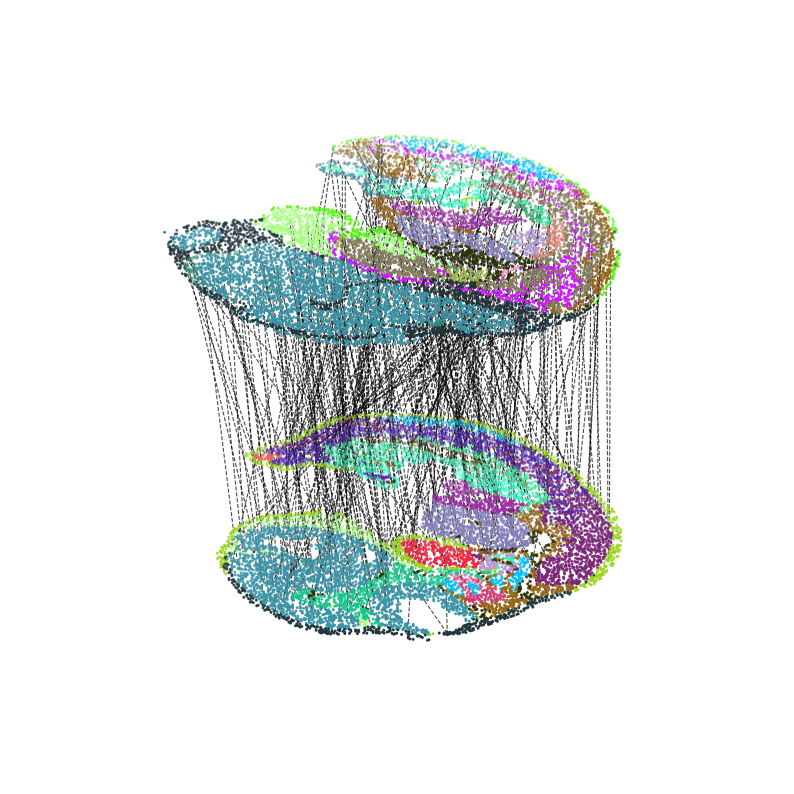

In [8]:
all_match = match_3D_multi(adata1_df, adata2_df, matching, meta='celltype',
                              scale_coordinate=True, subsample_size=300)

all_match.draw_3D(size=[10, 12], line_width=0.8, point_size=[1.2, 1.2],
                  line_color='black', show_error=False, hide_axis=True)

In [9]:
all_celltypes = np.unique(adata_all.obs['annotation']).tolist()

/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:242: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.celltypes = set(self.dataset_A[meta].append(self.dataset_B[meta]))


dataset1: 18 cell types; dataset2: 22 cell types; 
                    Total :29 celltypes; Overlap: 11 cell types 
                    Not overlap :[['Dermomyotome', 'Sclerotome', 'Surface ectoderm', 'Head mesenchyme', 'Inner ear', 'Branchial arch', 'Spinal cord', 'Cartilage primordium', 'Mucosal epithelium', 'Mesentery', 'Choroid plexus', 'Pancreas', 'Ovary', 'Muscle', 'Epidermis', 'Mesothelium', 'Kidney', 'Sympathetic nerve']]
Subsample 10000 cell pairs from 10001


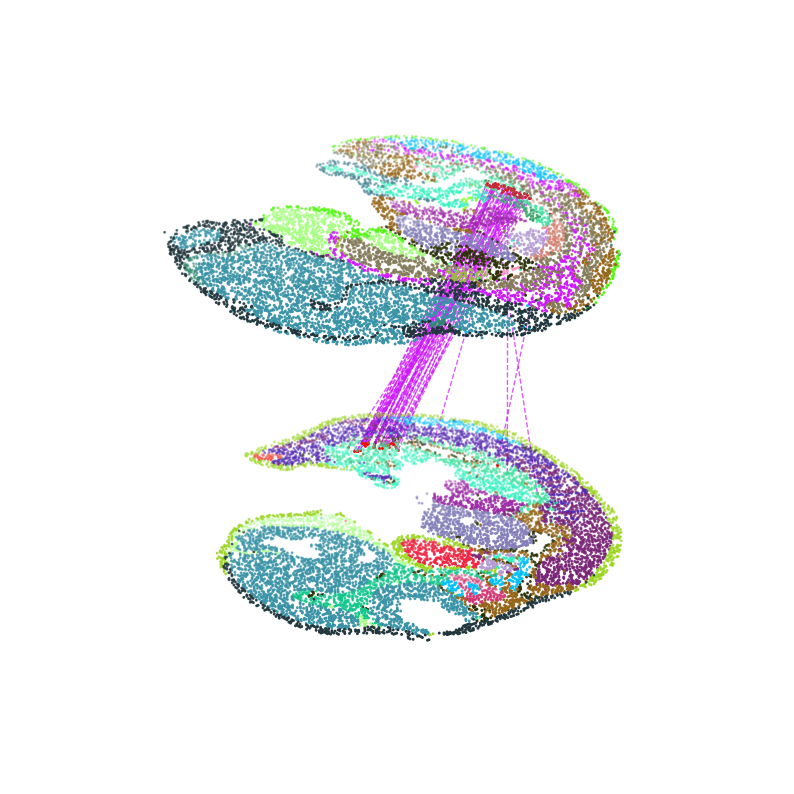

In [11]:
kidney_match = match_3D_celltype(adata1_df, adata2_df, matching, meta='celltype',
                                highlight_celltype=[['Urogenital ridge'],['Kidney']],
                                scale_coordinate=True,
                                subsample_size=10000, highlight_cell=['red'])
kidney_match.draw_3D(size=[10, 12], line_width=1, point_size=[1.2,1.2], hide_axis=True)